In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns    # matplotlib 升级版

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 一、数据预处理

In [3]:
# parse_dates  将指定列转为日期类型
df = pd.read_csv('data/ccf_offline_stage1_train.csv', parse_dates=['Date_received', 'Date'])
df.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20:00,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,20:01,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,20:01,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,20:01,0.0,2016-06-13,NaT


In [4]:
# info没有办法查询缺失值，就要使用函数查询
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
User_id          1048575 non-null int64
Merchant_id      1048575 non-null int64
Coupon_id        629824 non-null float64
Discount_rate    629824 non-null object
Distance         985589 non-null float64
Date_received    629824 non-null datetime64[ns]
Date             463717 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 56.0+ MB


In [5]:
df.describe()

,User_id,Merchant_id,Coupon_id,Distance
count,1.048575e+06,1.048575e+06,629824.000000,985589.000000
mean,3.634056e+06,4.040494e+03,6815.953897,2.362526
std,2.103673e+06,2.435226e+03,4175.340483,3.485198
min,4.000000e+00,1.000000e+00,1.000000,0.000000
25%,1.832923e+06,2.005000e+03,2840.000000,0.000000
50%,3.586645e+06,3.532000e+03,7430.000000,0.000000
75%,5.442910e+06,6.316000e+03,10323.000000,3.000000
max,7.361024e+06,8.856000e+03,14045.000000,10.000000


### 分别查看每列缺失值的数量和比例

In [6]:
# isnull()
df.isnull().sum()/df.shape[0]

User_id          0.000000
Merchant_id      0.000000
Coupon_id        0.399352
Discount_rate    0.399352
Distance         0.060068
Date_received    0.399352
Date             0.557765
dtype: float64

将折扣率满减形式，转化为折扣形式  
20:1    1/20  
150:20  20/150

In [7]:
def fn(x):
    # 如果有：，证明是满减类型，进行对应处理
    if ':' in str(x):
        a = x.split(':')
        return 1 - (float(a[1]) / float(a[0]))
    elif '.' in str(x): # 以折扣形式出现
        return float(x)
    else:
        return np.NaN
df['Discount_rate'] = df['Discount_rate'].map(fn)
df.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,0.866667,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,0.950000,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,0.950000,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,0.950000,0.0,2016-06-13,NaT


### 验证优惠券id、折扣率、日期接收时间缺失位置是否相同

In [8]:
np.all([True, False, False]) # 逻辑与

False

In [9]:
df['Coupon_id'].isnull().head()

0     True
1    False
2    False
3    False
4    False
Name: Coupon_id, dtype: bool

In [10]:
# 分别查看这三列的数据是否为空
n1 = df['Coupon_id'].isnull()
n2 = df['Discount_rate'].isnull()
n3 = df['Date_received'].isnull()
# np.all 来进行验证
np.all(n1==n2)

True

In [11]:
np.all(n2==n3)

True

In [12]:
np.all([n1==n3])

True

未领优惠券消费用户  
领取优惠券未消费用户  
领取优惠券消费用户  
三种用户的人数 条形图  
三种用户人数的比例  饼状图

In [13]:
# 未领优惠券消费用户  coupon_id 空   date 有数据
l1 = df[(df['Coupon_id'].isnull())&(df['Date'].notnull())].count()['User_id']
# 领取优惠券未消费用户
l2 = df[(df['Coupon_id'].notnull())&(df['Date'].isnull())].count()['User_id']
# 领取优惠券消费用户
l3 = df[(df['Coupon_id'].notnull())&(df['Date'].notnull())].count()['User_id']
l = [l1, l2, l3]
l

[418751, 584858, 44966]

([<matplotlib.axis.XTick at 0x2eb17f7af28>,
 <a list of 3 Text xticklabel objects>)

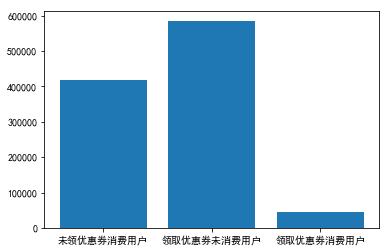

In [14]:
plt.bar([1, 2, 3],l)
plt.xticks([1, 2, 3], ['未领优惠券消费用户', '领取优惠券未消费用户', '领取优惠券消费用户'])

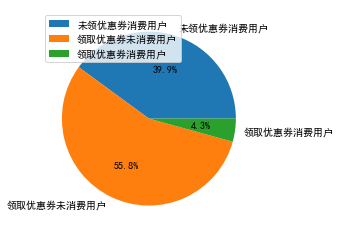

In [15]:
plt.pie(l, autopct='%1.1f%%',
        labels=['未领优惠券消费用户', '领取优惠券未消费用户', '领取优惠券消费用户'])
plt.legend(loc='upper left')

## 3.1在有券消费人群中，根据商户分析距离和优惠折扣

In [16]:
# 有券消费用户
cou_date = df[(df['Coupon_id'].notnull())&(df['Date'].notnull())]
cou_date.head()
# 分析商户折扣力度，距离消费者距离
m_cou_date = cou_date.groupby('Merchant_id').mean()[['Discount_rate', 'Distance']]
m_cou_date.head()

,Discount_rate,Distance
Merchant_id,,
3,0.666667,0.0
4,0.833333,0.0
5,0.750000,NaN
13,0.900000,0.0
14,0.833333,0.0


### 求商户的折扣统计、距离统计

count    3296.000000
mean        0.882292
std         0.087820
min         0.200000
25%         0.833333
50%         0.900000
75%         0.950000
max         0.990000
Name: Discount_rate, dtype: float64

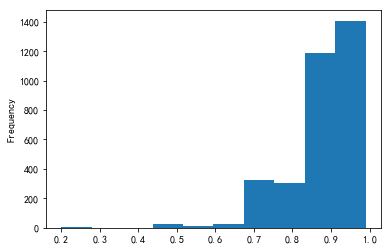

In [19]:
# 平均88折  中位数9折
m_cou_date['Discount_rate'].plot(kind='hist')
m_cou_date['Discount_rate'].describe()

count    3001.000000
mean        1.745209
std         2.625708
min         0.000000
25%         0.000000
50%         0.500000
75%         2.500000
max        10.000000
Name: Distance, dtype: float64

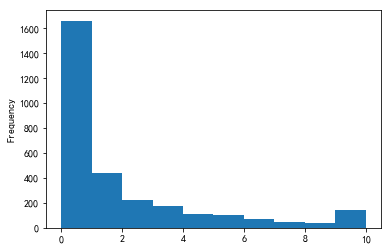

In [22]:
# 消费券在1km之内用户消费欲望比较大
m_cou_date['Distance'].plot(kind='hist')
m_cou_date['Distance'].describe()

## 3.2在有券消费人群中，根据用户分析距离和优惠折扣

count    27594.000000
mean         0.828891
std          0.104124
min          0.200000
25%          0.791667
50%          0.833333
75%          0.900000
max          0.990000
Name: Discount_rate, dtype: float64

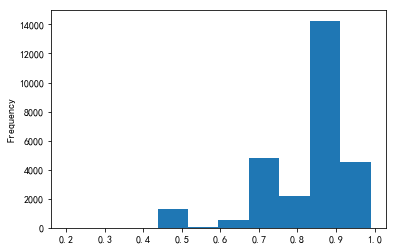

In [27]:
# 商户平均值88折，用户均值82折 用户更喜欢折扣更低的服务
# 商户折扣标准差0.08，用户标准差0.1   用户对折扣关注度相对会低一些
u_cou_data = cou_date.groupby('User_id').mean()[['Discount_rate', 'Distance']]
u_cou_data['Discount_rate'].plot(kind='hist')
u_cou_data['Discount_rate'].describe()

count    24463.000000
mean         1.181504
std          2.423107
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         10.000000
Name: Distance, dtype: float64

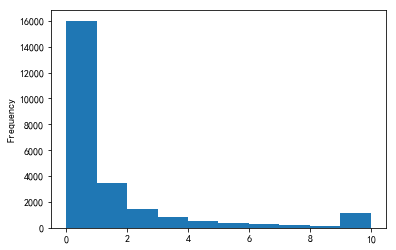

In [28]:
u_cou_data['Distance'].plot(kind='hist')
u_cou_data['Distance'].describe()

## 3.3 无券消费人群中，用户消费距离均值

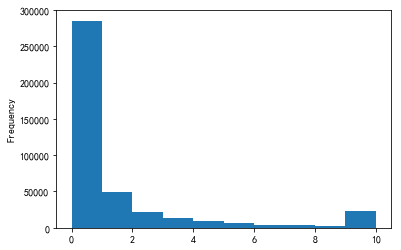

In [30]:
df[(df['Coupon_id'].isnull())&(df['Date'].notnull())]['Distance'].plot(kind='hist')

## 3.4持卷到店消费人数最多的商户

In [41]:
# 根据商户进行分组，对用户id去重分析，消费用户最多的商户
df1 = cou_date.groupby('Merchant_id')['User_id'].apply(lambda x: len(x.unique())).sort_values(ascending=False)
# 获取到店消费人数大于500的所有商户id
df1 = df1.reset_index()
df1[df1.User_id>=500]

,Merchant_id,User_id
0,5341,1652
1,760,1527
2,3381,1274
3,6485,1198
4,2099,845
5,2934,812
6,450,661
7,7555,573
8,3532,559
9,1520,526


### 3.4.1分别统计商户持卷到点消费用户数量占比（0-100,100-200,200-300,300-400,400-500,500-2000）

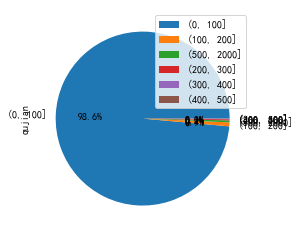

In [50]:
# pd.cut
# 编写切分区间
bins = [i*100 for i in range(6)]
bins.append(2000)
# bins
df1['qujian'] = pd.cut(df1['User_id'], bins)
df1.head()
# pie
df1['qujian'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.legend()

## 3.5持卷消费超过500个用户的商家平均的折扣

In [59]:
# 持卷消费超过500个用户所有数据， 商户的平均折扣，平均距离   内连接
df1 = cou_date.groupby('Merchant_id')['User_id'].apply(lambda x: len(x.unique())).sort_values(ascending=False).reset_index()
df1 = df1[df1['User_id']>500]
# 商户平均折扣
df2 = cou_date.groupby('Merchant_id').mean()[['Discount_rate', 'Distance']].reset_index()
df3 = pd.merge(df1, df2, on='Merchant_id')
df3

,Merchant_id,User_id,Discount_rate,Distance
0,5341,1652,0.828825,0.182232
1,760,1527,0.801239,0.336247
2,3381,1274,0.747143,1.641216
3,6485,1198,0.772500,0.391279
4,2099,845,0.900000,0.926559
5,2934,812,0.833333,1.127353
6,450,661,0.822785,0.827338
7,7555,573,0.831247,1.415307
8,3532,559,0.854461,0.241431
9,1520,526,0.925420,NaN


## 3.6分析到点消费人数与平均距离、折扣力度的相关性

皮尔逊系数：比较特征（字段）之间相关性的数据值。  
输出结果范围[-1, 1]  
皮尔逊输出值大于0 特征之间正相关性，小于0，特征之间负相关  
皮尔逊系数数值大于0.6以上，特征之间存在强关系

In [60]:
df3.corr() # 皮尔逊系数
# 用户数量和折扣率均值之间负相关（餐厅到访人数越多，折扣越低）

,Merchant_id,User_id,Discount_rate,Distance
Merchant_id,1.000000,-0.072013,-0.217470,0.009975
User_id,-0.072013,1.000000,-0.597572,-0.193384
Discount_rate,-0.217470,-0.597572,1.000000,-0.246791
Distance,0.009975,-0.193384,-0.246791,1.000000


使用可视化方式显示特征之间的相关性

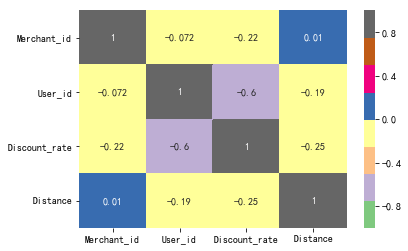

In [65]:
# 热力图，可以去显示皮尔逊系数数值的大小进行颜色调整
# annot=True 显示数据结果, cmap color map 调色板参数，vmax,vmin  设置对应颜色数值的最大值和最小值
sns.heatmap(df3.corr(), annot=True, cmap='Accent', vmax=1, vmin=-1)

分析每个商户，到店消费总用户、使用折扣卷用户、用户到店距离之间的相关性

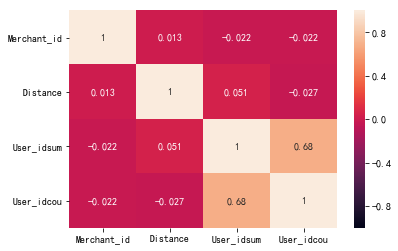

In [72]:
# 按照商户分组，查看消费总用户数量
df1 = df.groupby('Merchant_id')['User_id'].apply(lambda x: len(x.unique())).reset_index()
# 按照商户分组，查看使用折扣卷用户数量
df2 = cou_date.groupby('Merchant_id')['User_id'].apply(lambda x: len(x.unique())).reset_index()
# 按照商户分组，查看所有消费用户到店距离
df3 = df.groupby('Merchant_id').mean()['Distance'].reset_index()
# 将上面三个数据进行拼接
# 先df1,df2  suffixes 相同列明起后缀
df4 = pd.merge(df1, df2, on='Merchant_id', suffixes=['sum', 'cou'])
# df3 df4合并
df4 = pd.merge(df3, df4, on='Merchant_id')
# 使用皮尔逊系数查看数据间相关性
sns.heatmap(df4.corr(), annot=True, vmax=1, vmin=-1)

# 四、消费券分析

## 4.1查看消费券总发放量和使用量

In [73]:
# 查看消费券总发放量
print(df['Coupon_id'].count())
# 总使用量
print(df['Date'].count())

629824
463717


## 4.2查看有用的日期并排序

In [76]:
# 查看所有领券的日期并排序
df1 = df[df['Date_received'].notnull()]['Date_received'].sort_values().unique()
# 查看所有消费日期并排序
df2 = df[df['Date'].notnull()]['Date'].sort_values().unique()

## 4.3每天消费券的使用量和发放量

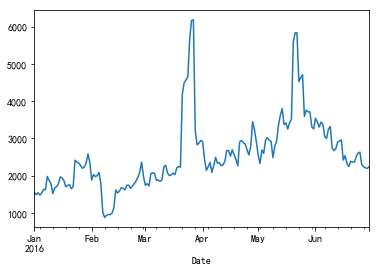

In [78]:
# 发放量
df.groupby('Date').count()['User_id'].plot()

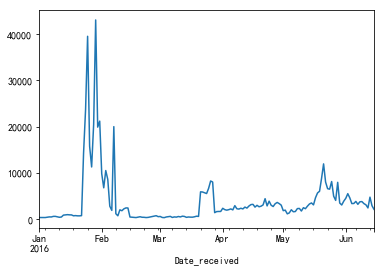

In [79]:
# 使用量
df.groupby('Date_received').count()['User_id'].plot()

## 4.4分析用户领取消费券到使用消费卷相差时间，进行可视化处理

D:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


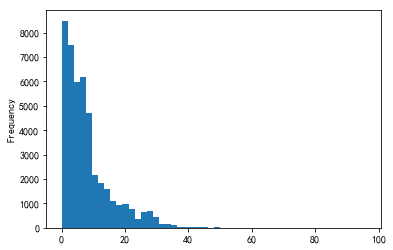

In [84]:
# 计算使用时间到领取时间之间的差值
cou_date['time_diff'] = cou_date['Date'] - cou_date['Date_received']
cou_date['time_diff'] = cou_date['time_diff']/np.timedelta64(1, 'D') # 将日期类型转换为天
# 处理方式一，使用直方图统计
cou_date['time_diff'].plot(kind='hist', bins=50)

## 4.5 分析用户领取消费券使用率（使用cut函数，每20%进行一次切分，显示不同使用率比例）

In [88]:
# 查找出领取消费券并使用的数据信息
df1 = df[(df['Date_received'].notnull())&(df['Date'].notnull())]
# 查找出领取消费券但是没有使用的数据信息
df2 = df[(df['Date_received'].notnull())&(df['Date'].isnull())]
# 查找出每个用户使用消费券个数
df3 = df1.groupby('User_id').count()['Merchant_id'].reset_index()
# 查找出每个用户未使用消费券个数
df4 = df2.groupby('User_id').count()['Discount_rate'].reset_index()
df5 = pd.merge(df3, df4)
df5.head()

,User_id,Merchant_id,Discount_rate
0,184,1,1
1,687,2,6
2,696,4,5
3,947,2,4
4,1673,2,4


In [89]:
# 计算概率
df5['rate'] = df5['Discount_rate'] / (df5['Discount_rate'] + df5['Merchant_id'])
df5.head()

,User_id,Merchant_id,Discount_rate,rate
0,184,1,1,0.500000
1,687,2,6,0.750000
2,696,4,5,0.555556
3,947,2,4,0.666667
4,1673,2,4,0.666667


In [90]:
bins = [i * 0.2 for i in range(6)]
df5['rate'] = pd.cut(df5['rate'], bins)
df5.head()

,User_id,Merchant_id,Discount_rate,rate
0,184,1,1,"(0.4, 0.6]"
1,687,2,6,"(0.6, 0.8]"
2,696,4,5,"(0.4, 0.6]"
3,947,2,4,"(0.6, 0.8]"
4,1673,2,4,"(0.6, 0.8]"


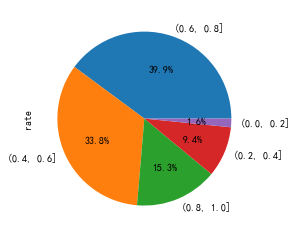

In [95]:
df5['rate'].value_counts().plot(kind='pie', autopct='%1.1f%%')
# plt.legend()

## 4.6分析用户消费使用消费券的概率，同4.5使用可视化分析